In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #Returns a dictionary with the data
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [18]:
import numpy as np
X,y = mnist["data"], mnist["target"]
y = y.astype(int) # Convert y to a list of integers
X = ((X/255.) - .5)*2
print(X.shape, y.shape)
print(min(y), max(y))
print(type(X), type(y))
print(np.min(np.min(X)), np.max(np.max(X)))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

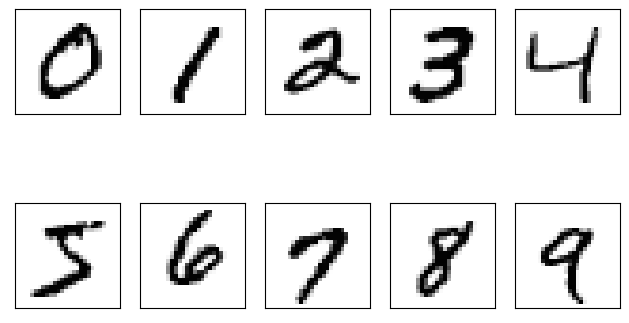

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    matchlist = [i for i, x in enumerate(y==i) if x]
    img = X[matchlist[0]].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(60000, 784) (10000, 784) (60000,) (10000,)


In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
import collections
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)
for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X_train[train_index,:]
    y_train_strat = y_train[train_index]
    
    X_dev_strat = X_train[val_index,:]
    y_dev_strat = y_train[val_index]

print(X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [22]:
# Define key hyperparameters
class hyperparam:
    num_hid1_units = 300
    num_hid2_units = 100
    num_classes = 10
    input_dim = 28*28
    lr = 0.05 # Learning rate 
    num_epochs = 100 # Number of epochs
    bs = 50 # Mini-batch size
    momentum = 0.9

In [23]:
class myDataset(data.Dataset):
    def __init__(self,input_data,labels):
        # Initialize variables
        self.feats = input_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels) # returns the number of samples
    
    def __getitem__(self, index):
        X = self.feats[index,:]
        y = self.labels[index]
        
        return X, y
        

In [24]:
params = {'batch_size': hyperparam.bs,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': False,
          'pin_memory': True}

training_set = myDataset(X_train_strat, y_train_strat)
dev_set = myDataset(X_dev_strat, y_dev_strat)
test_set = myDataset(X_test, y_test)

training_gen = data.DataLoader(training_set, **params)
dev_gen = data.DataLoader(dev_set, **params)
testing_gen = data.DataLoader(test_set, **params)


In [25]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()

        self.num_hid1_units = hyperparam.num_hid1_units
        self.num_hid2_units = hyperparam.num_hid2_units
        self.num_classes = 10
        self.input_dim = 28 * 28
        self.dropout_rate = dropout_rate

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.conv1.bias)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(6, 10, 3, stride=1)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.conv2.bias)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Define the size of the input to the fully connected layer
        self.fc_input_size = self.calculate_fc_input_size()

        # Fully connected
        self.fc1 = nn.Linear(self.fc_input_size, self.num_classes)
        

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        hid1 = func.relu(self.conv1(x))
        hid2 = func.relu(self.conv2(hid1))
        hid2 = hid2.view(-1, self.fc_input_size)
        hid2 = self.dropout(hid2)
        out = self.fc1(hid2)
        out = func.softmax(out, dim=1)
        return out

    def calculate_fc_input_size(self):
        conv2_output_size = ((28 - 3) // 1) + 1
        conv2_output_size = ((conv2_output_size - 3) // 1) + 1
        fc_input_size = 10 * conv2_output_size * conv2_output_size
        return fc_input_size

In [26]:
# Define dropout rates
dropout_rates = [0.25, 0.5, 0.75]

# List to hold the models
models = []

# Create models with different dropout rates
for dropout_rate in dropout_rates:
    model = CNN(dropout_rate=dropout_rate)
    models.append(model)

In [27]:
# Training loop for each model
for idx, model in enumerate(models):
    print(f"Training Model {idx + 1} with dropout rate {dropout_rates[idx]}")
    
    # Create CNN model and define loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=hyperparam.lr, momentum=hyperparam.momentum)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, range(10, 101, 10), gamma=0.9)
    loss = nn.CrossEntropyLoss()
    
    best_dev_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    num_epochs_no_improve = 0
    tr_avgLoss_list = []
    dev_avgLoss_list = []
    tr_accuracy_list = []
    dev_accuracy_list = []

    for epoch in range(hyperparam.num_epochs):
        print(epoch)
        tr_num_correct = 0
        tr_num_samples = 0
        tr_total_loss = 0.0

        dev_num_correct = 0
        dev_num_samples = 0
        dev_total_loss = 0.0

        # Training
        model.train(True)
        with torch.set_grad_enabled(True):
            for local_batch, local_labels in training_gen:
                optimizer.zero_grad()

                local_batch = local_batch.float()
                local_labels = local_labels.float()
                local_batch, local_labels = Variable(local_batch), Variable(local_labels)

                out1 = model(local_batch)

                pLoss = loss(out1, local_labels.long())
                tr_total_loss += pLoss * hyperparam.bs

                pLoss.backward()
                optimizer.step()

                sel_class = torch.argmax(out1, dim=1)
                tr_num_correct += sel_class.eq(local_labels).sum().item()
                tr_num_samples += hyperparam.bs

            tr_avgLoss = tr_total_loss / len(training_gen.dataset)
            tr_avgLoss_list.append(tr_avgLoss)

            tr_accuracy = tr_num_correct / tr_num_samples
            tr_accuracy_list.append(tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for local_batch, local_labels in dev_gen:
                local_batch = local_batch.float()
                local_labels = local_labels.float()
                local_batch, local_labels = Variable(local_batch), Variable(local_labels)

                out = model(local_batch)

                pLoss = loss(out, local_labels.long())
                dev_total_loss += pLoss * local_batch.size(0)

                sel_class = torch.argmax(out, dim=1)
                dev_num_correct += sel_class.eq(local_labels).sum().item()
                dev_num_samples += local_batch.size(0)

            dev_avgLoss = dev_total_loss / len(dev_gen.dataset)
            dev_avgLoss_list.append(dev_avgLoss)

            dev_accuracy = dev_num_correct / dev_num_samples
            dev_accuracy_list.append(dev_accuracy)

            if dev_avgLoss < best_dev_loss:
                best_dev_loss = dev_avgLoss
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1
                if num_epochs_no_improve >= patience:
                    print("Early stopping! No improvement for", patience, "epochs.")
                    break


Training Model 1 with dropout rate 0.25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Early stopping! No improvement for 10 epochs.
Training Model 2 with dropout rate 0.5
0
1
2
3
4
5
6
7
8
9
10
11
12
Early stopping! No improvement for 10 epochs.
Training Model 3 with dropout rate 0.75
0
1
2
3
4
5
6
7
8
9
10
11
12
Early stopping! No improvement for 10 epochs.


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

for idx, model in enumerate(models):
    # Testing
    model.eval()
    with torch.no_grad():
        test_total_loss = 0.0
        test_num_samples = 0
        test_num_correct = 0
        pred = []
        y_testnew = []

        for local_batch, local_labels in testing_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            out1 = model(local_batch)
            pLoss = loss(out1, local_labels.long())
            test_total_loss += pLoss * len(local_labels)
            sel_class = torch.argmax(out1, dim=1)
            pred += sel_class.tolist()
            y_testnew += local_labels.tolist()

            test_num_correct += accuracy_score(local_labels, sel_class, normalize=False)
            test_num_samples += len(local_labels)

        test_avgLoss = test_total_loss / len(testing_gen.dataset)
        test_accuracy = test_num_correct / test_num_samples

        print('Test: Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss, test_accuracy))

        conf_matrix = confusion_matrix(y_testnew, pred)
        print("Confusion Matrix:\n", conf_matrix)

Test: Loss: 1.503693223, Test Accuracy: 0.95750
Confusion Matrix:
 [[ 975    0    2    0    1    0    2    0    0    0]
 [   0 1127    1    4    0    0    3    0    0    0]
 [   3    5  986   30    2    0    1    3    2    0]
 [   3    0    3  994    0    2    1    6    0    1]
 [   0    1    2    3  957    0    0    1    2   16]
 [  11    0    1   40    0  829    4    0    4    3]
 [  10    4    2    1   14    5  921    0    1    0]
 [   0    2   22   12    1    2    0  976    1   12]
 [  21    7   12   24    8    3   21    5  846   27]
 [   6    6    1   14    6    4    0    8    0  964]]
Test: Loss: 1.687307596, Test Accuracy: 0.77380
Confusion Matrix:
 [[ 961    0    0    6    0    0   10    2    1    0]
 [   0 1123    0    1    4    0    3    1    3    0]
 [  15  322    0  471   11    0   16   36  154    7]
 [   0    3    0  980    0    0    0    6   17    4]
 [   2    2    0    3  909    0   40    0    1   25]
 [  53    2    0  487    0    0   23    4  283   40]
 [  18    3    0 

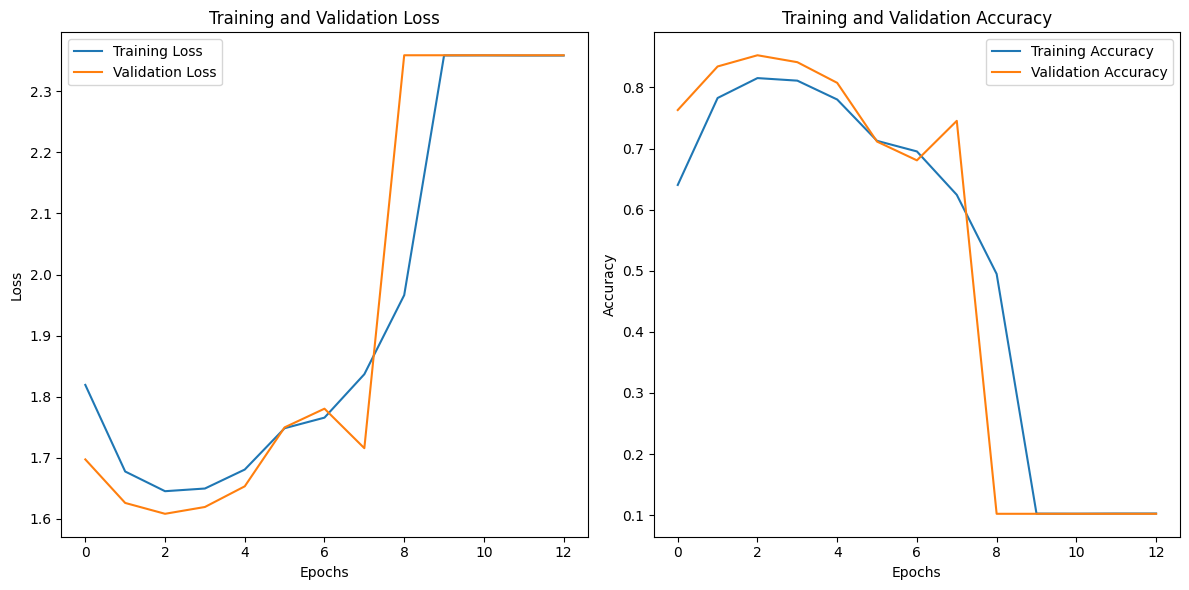

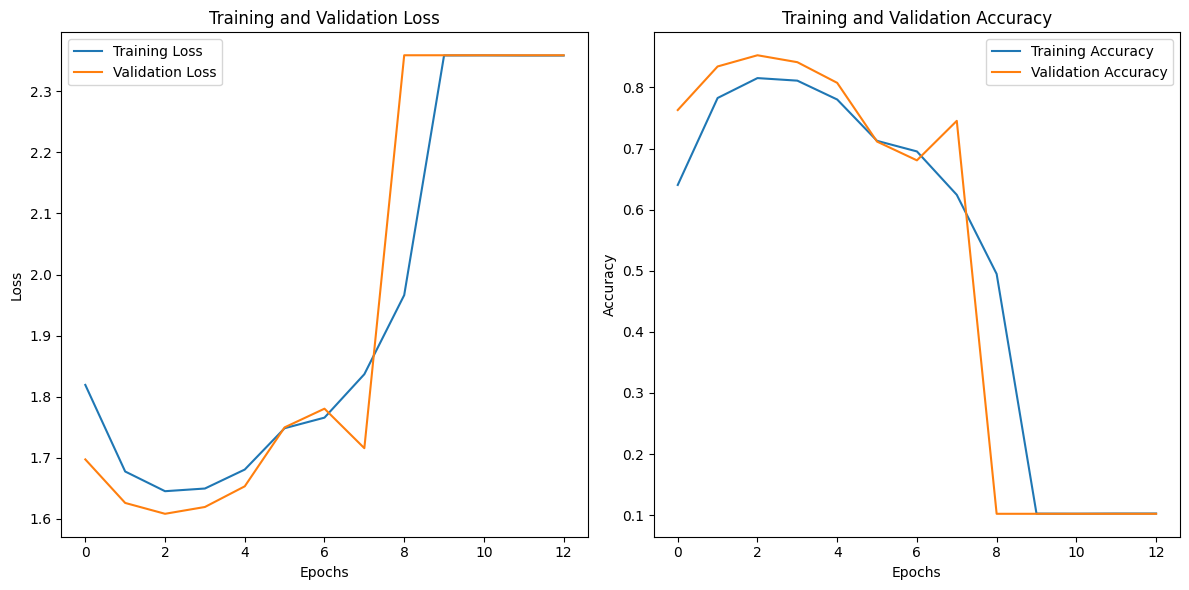

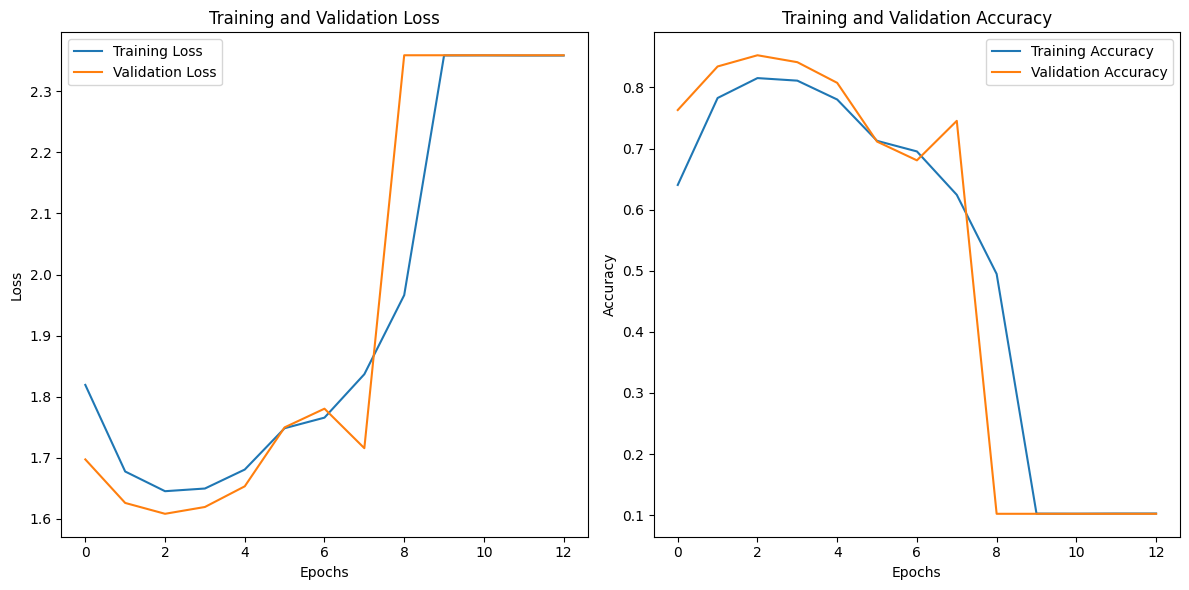

In [29]:
import numpy as np
import matplotlib.pyplot as plt

for idx, model in enumerate(models):
    # Convert PyTorch tensors to NumPy arrays
    tr_avgLoss_np = [loss.detach().numpy() for loss in tr_avgLoss_list]
    dev_avgLoss_np = [loss.detach().numpy() for loss in dev_avgLoss_list]

    # Plot learning curves
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(len(tr_avgLoss_np)), tr_avgLoss_np, label='Training Loss')
    plt.plot(range(len(dev_avgLoss_np)), dev_avgLoss_np, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(len(tr_accuracy_list)), tr_accuracy_list, label='Training Accuracy')
    plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
#With using a dropout value of .25 our new model fits the data better then the baseline. When using .5 it is very close to the baseline and when using .75 it is way off the baseline. This could be because when we use a high drop off it loses too many neurons.